In [17]:
import os
import re
import matplotlib
import imageio
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import signal
import numpy as np 
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
plt.style.use('seaborn-darkgrid')

In [2]:
files = {os.path.splitext(k)[0]: {} for k in os.listdir('data') if '.csv' in os.path.splitext(k)[1]}

for i,file in enumerate(os.listdir('data')):
    ext = os.path.splitext(file)[1]
    name = os.path.splitext(file)[0]
    if '.csv' in ext:
        df = pd.read_csv(f'data/{file}')
        files[name] = df

In [140]:
def hz(frec):
    hz_ = 1/( (frec+1) * 120 * 8*10**-9 )
    return hz_

def vars_(df):
    X = np.array(df['X']) #* 1000
    Y = np.array(df['Y']) #* 1000
    R = np.sqrt(X**2 + Y**2)
    T = np.arctan(Y/X)
    return X,Y,R,T

def fc(frec):
    hz_ =  1/(2 * np.pi * (2 ** frec ) * 8 )*10**9
    return hz_

def transf(frec,C0,L,R,R2):
    w = frec * np.pi * 2
    A = C0**2*R2**2*w**2*(C0**2*L**2*w**4 + C0**2*R**2*w**2 - 4*C0*L*w**2 + 4)
    B = (C0**4*L**2*R2**2*w**6 + C0**4*R**2*R2**2*w**4 - 4*C0**3*L*R2**2*w**4 + C0**2*L**2*w**4 + C0**2*R**2*w**2 + 2*C0**2*R*R2*w**2 + 4*C0**2*R2**2*w**2 - 2*C0*L*w**2 + 1)
    func = A/B
    return func

def transf_original(frec,C,L,R,R2):
    w = frec * np.pi * 2
    t = R2/(np.sqrt( (R+R2)**2  + ( (w*L) - (1/(w*C)) )**2 ))
    return t

L=10 * 10**-3
C0= 100 *10**-9 
R = 12
R2 = 50

Covariance of coefficients:
[[ 3.85136029e-06 -5.32952484e-01 -2.58492045e+03 -2.62649191e+03]
 [-5.32952484e-01  7.37501372e+04  3.57702128e+08  3.63454801e+08]
 [-2.58492045e+03  3.57702128e+08  1.73492305e+12  1.76282460e+12]
 [-2.62649191e+03  3.63454801e+08  1.76282460e+12  1.79117487e+12]]
C0: 8.555640462399534e-08
L: 0.011843695464837593
R: 57.444051129922116
R2: 58.36794041414042
[[ 1.10959234e-02 -2.89449737e+02 -8.61336525e+05 -3.55813660e+05]
 [-2.89449737e+02  7.55062439e+06  2.24689393e+10  9.28180252e+09]
 [-8.61336525e+05  2.24689393e+10  6.68624485e+13  2.76205313e+13]
 [-3.55813660e+05  9.28180252e+09  2.76205313e+13  1.14098985e+13]]
C0: 2.1003533206964342e-07
L: 0.005471570466757282
R: 16.282397620024422
R2: 6.726111167747592


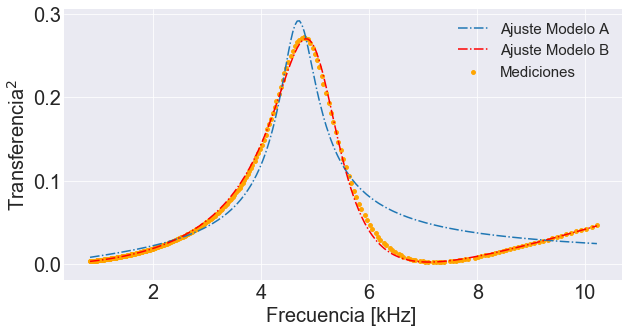

31414.49778647527


In [201]:
x,y,r,t = vars_(files['27']) 
r=2.02*r
frec = hz(files[file]['frecs'])


param_o, param_cov_o = curve_fit(transf_original,frec,r**2, p0=[C0,L,R,R2]) 
param, param_cov = curve_fit(transf,frec,r**2, p0=[C0,L,50,R2])

print("Covariance of coefficients:") 
print(param_cov) 
print(f'C0: {param[0]}')
print(f'L: {param[1]}')
print(f'R: {param[2]}')
print(f'R2: {param[3]}')

print(param_cov_o) 
print(f'C0: {param_o[0]}')
print(f'L: {param_o[1]}')
print(f'R: {param_o[2]}')
print(f'R2: {param_o[3]}')

%matplotlib inline
plt.figure(figsize=(10,5))
plt.scatter(frec/1000,r**2, s= 15, label ="Mediciones",color='orange')
plt.plot(frec/1000,transf_original(frec,param_o[0],param_o[1],param_o[2],param_o[3]), label ="Ajuste Modelo A",ls='dashdot') 
plt.plot(frec/1000,transf(frec,param[0],param[1],param[2],param[3]), label ="Ajuste Modelo B",ls='dashdot',color='red') 
plt.ylabel(r'Transferencia$^{2}$',fontsize=20)
plt.xlabel(r'Frecuencia [kHz] ',fontsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.legend(fontsize=15)
plt.show()
print(1/np.sqrt(param[0]*param[1]))

31071.709265190857


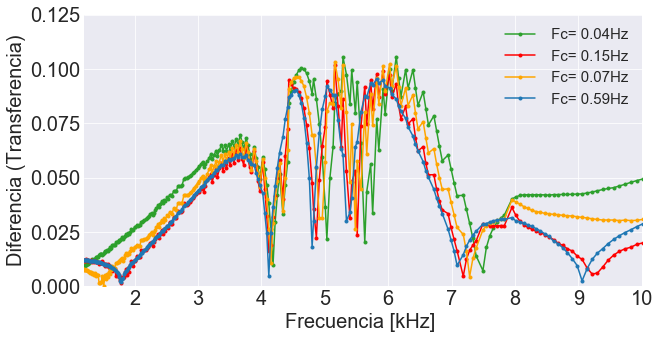

In [132]:
fs = ['29', '27', '28', '25']
c = ['C2','red','orange','C0']
mod_a = []
mod_b = []
plt.figure(figsize=(10,5))
for i,f in enumerate(fs):
    x,y,r,t = vars_(files[f]) 
    r=2.02*r
    frec = hz(files[f]['frecs'])


    param_o, param_cov_o = curve_fit(transf_original,frec,r**2, p0=[C0,L,R,R2]) 
    param, param_cov = curve_fit(transf,frec,r**2, p0=[C0,L,50,R2])

    data = r**2
    modelo_a = transf_original(frec,param_o[0],param_o[1],param_o[2],param_o[3])
    modelo_b = transf(frec,param[0],param[1],param[2],param[3])

    dist_a = np.abs(data-modelo_a)
    dist_b = np.abs(data-modelo_b)
    mod_a.append(dist_a)
    mod_b.append(dist_b)
    
    #plt.plot(frec/1000,dist_a, label =f"Ajuste Modelo A, Fc= {f}",color=c[i]) 
    plt.plot(frec/1000,np.sqrt(dist_b),'.-', label =f" Fc= {np.round(fc(int(f)),2)}Hz",color=c[i]) 
plt.ylabel(r'Diferencia (Transferencia)',fontsize=20)
plt.xlabel(r'Frecuencia [kHz] ',fontsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.legend(fontsize=15)
plt.xlim([1.2,10])
plt.ylim([0,0.125])
print(1/np.sqrt(param[0]*param[1]))

(1.2, 10)

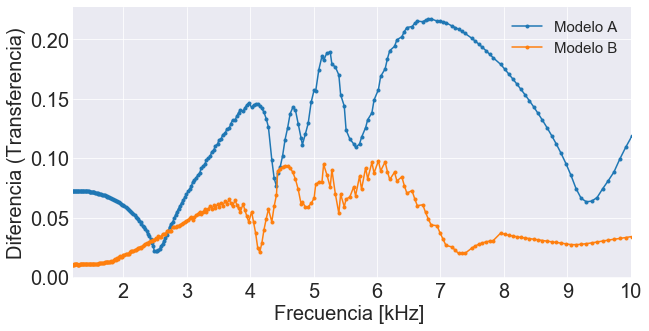

In [125]:
a = np.transpose(np.array(mod_a))
b = np.transpose(np.array(mod_b))
a_ = []
b_ = []

for i in range(len(a)):
    a_.append(np.mean(a[i]))
    b_.append(np.mean(b[i]))
plt.figure(figsize=(10,5))
plt.plot(frec/1000,np.sqrt(a_),'.-',label='Modelo A')
plt.plot(frec/1000,np.sqrt(b_),'.-',label='Modelo B')
plt.ylabel(r'Diferencia (Transferencia)',fontsize=20)
plt.xlabel(r'Frecuencia [kHz] ',fontsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.legend(fontsize=15)
plt.xlim(1.2,10)

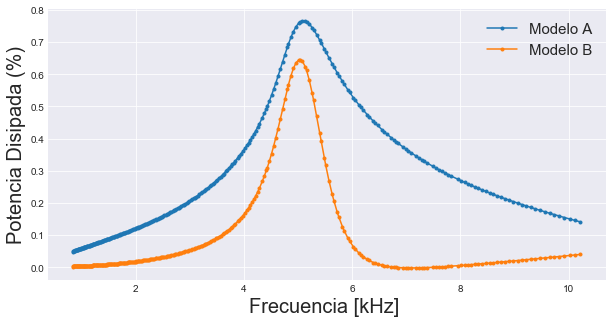

In [212]:
# porentaje de potencia disipada
%matplotlib inline
pot_a =  1 - np.abs((r**2 - transf_original(frec,C0,L,R,R2) + 1) /(transf_original(frec,C0,L,R,R2) + 1)) 
pot_b =1 - np.abs((r**2 - transf(frec,C0,L,R,R2) + 1) / (transf(frec,C0,L,R,R2) + 1) )
plt.figure(figsize=(10,5))
plt.plot(frec/1000,pot_a,'.-',label='Modelo A')
plt.plot(frec/1000,pot_b,'.-',label='Modelo B')
plt.ylabel(r'Potencia Disipada (%)',fontsize=20)
plt.xlabel(r'Frecuencia [kHz] ',fontsize=20)
plt.legend(fontsize=15)

(1.2, 10)

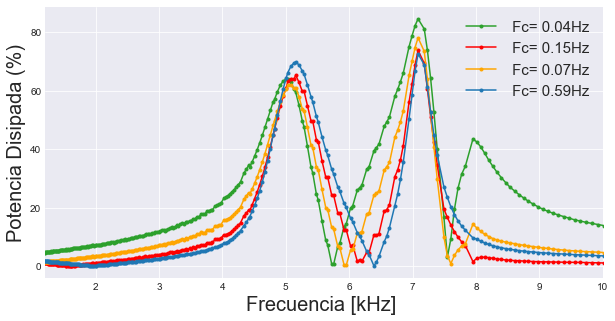

In [197]:
%matplotlib inline

plt.figure(figsize=(10,5))
for i,f in enumerate(fs):
    x,y,r,t = vars_(files[f]) 
    r=2.02*r
    frec = hz(files[f]['frecs'])

    pot_b = np.abs(r - np.sqrt(transf(frec,C0,L,R,R2))) / np.abs(r) *100
    
    #plt.plot(frec/1000,dist_a, label =f"Ajuste Modelo A, Fc= {f}",color=c[i]) 
    plt.plot(frec/1000,pot_b,'.-', label =f" Fc= {np.round(fc(int(f)),2)}Hz",color=c[i]) 
plt.ylabel(r'Potencia Disipada (%)',fontsize=20)
plt.xlabel(r'Frecuencia [kHz] ',fontsize=20)
plt.legend(fontsize=15)
plt.xlim([1.2,10])

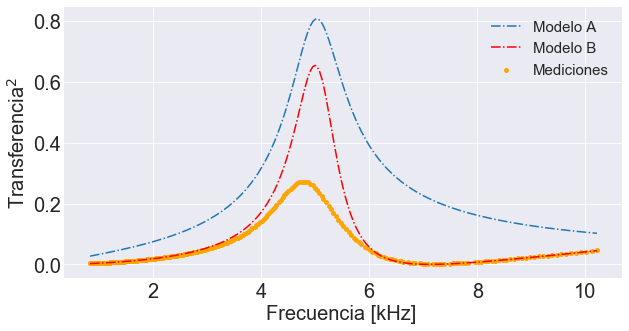

In [193]:
plt.figure(figsize=(10,5))
plt.scatter(frec/1000,r**2, s= 15, label ="Mediciones",color='orange')
plt.plot(frec/1000,transf_original(frec,C0,L,R,R2) , label ="Modelo A",ls='dashdot') 
plt.plot(frec/1000,transf(frec,C0,L,R,R2) , label ="Modelo B",ls='dashdot',color='red') 
plt.ylabel(r'Transferencia$^{2}$',fontsize=20)
plt.xlabel(r'Frecuencia [kHz] ',fontsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.legend(fontsize=15)
plt.show()

31071.709265190857


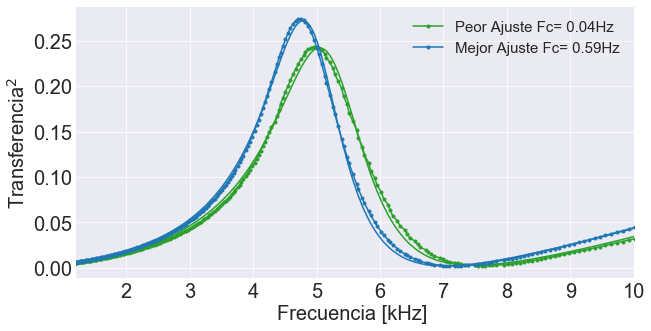

In [203]:
fs = ['29', '25']
c = ['C2','C0']
lab = ['Peor','Mejor']
plt.figure(figsize=(10,5))
for i,f in enumerate(fs):
    x,y,r,t = vars_(files[f]) 
    r=2.02*r
    frec = hz(files[f]['frecs'])


    param_o, param_cov_o = curve_fit(transf_original,frec,r**2, p0=[C0,L,R,R2]) 
    param, param_cov = curve_fit(transf,frec,r**2, p0=[C0,L,50,R2])

    data = r**2
    modelo_a = transf_original(frec,param_o[0],param_o[1],param_o[2],param_o[3])
    modelo_b = transf(frec,param[0],param[1],param[2],param[3])

    
    plt.plot(frec/1000,modelo_b,color=c[i]) 
    plt.plot(frec/1000,data,'.-',color=c[i],label =f"{lab[i]} Ajuste Fc= {np.round(fc(int(f)),2)}Hz") 
plt.ylabel(r'Transferencia$^2$',fontsize=20)
plt.xlabel(r'Frecuencia [kHz] ',fontsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.legend(fontsize=15)
plt.xlim([1.2,10])
#plt.ylim([0,0.0125])
print(1/np.sqrt(param[0]*param[1])) 